## Data Analysis Interview Challenge

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
import numpy as np
import datetime
from sklearn import preprocessing
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
import sklearn.metrics as m
import itertools
import time

### Part 1 ‑ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them

In [159]:
logins_df = pd.read_json('logins.json')
logins_df[:2]

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10


In [160]:
print(logins_df.login_time.size)
print(logins_df.dtypes)
print(logins_df.isnull().sum())
print(logins_df.describe())

93142
login_time    datetime64[ns]
dtype: object
login_time    0
dtype: int64
                 login_time
count                 93142
unique                92265
top     1970-02-12 11:16:53
freq                      3
first   1970-01-01 20:12:16
last    1970-04-13 18:57:38


In [161]:
logins_df['login_activity_15min'] = 1
logins_df[:2]

,login_time,login_activity_15min
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1


In [162]:
logins_df = logins_df.set_index('login_time')
logins_df[:2]

,login_activity_15min
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1


In [163]:
logins_df = logins_df.resample('15min').apply({'login_activity_15min':'count'})

In [164]:
print(len(logins_df))
logins_df[:2]

9788


,login_activity_15min
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6


In [165]:
logins_df["login_activity_hour"] = logins_df.resample('60min').sum()
logins_df[:2]

,login_activity_15min,login_activity_hour
login_time,,
1970-01-01 20:00:00,2,24.0
1970-01-01 20:15:00,6,NaN


In [166]:
logins_df.login_activity_hour.fillna(0, inplace=True)
logins_df[:2]

,login_activity_15min,login_activity_hour
login_time,,
1970-01-01 20:00:00,2,24.0
1970-01-01 20:15:00,6,0.0


In [167]:
logins_df = logins_df.reset_index()
logins_df

,login_time,login_activity_15min,login_activity_hour
0,1970-01-01 20:00:00,2,24.0
1,1970-01-01 20:15:00,6,0.0
2,1970-01-01 20:30:00,9,0.0
3,1970-01-01 20:45:00,7,0.0
4,1970-01-01 21:00:00,1,9.0
...,...,...,...
9783,1970-04-13 17:45:00,5,0.0
9784,1970-04-13 18:00:00,5,20.0
9785,1970-04-13 18:15:00,2,0.0
9786,1970-04-13 18:30:00,7,0.0


In [168]:
logins_df["day_of_month"] = logins_df.login_time.dt.day
logins_df["time_of_day"] = logins_df.login_time.dt.time
logins_df["hour_of_day"] = logins_df.login_time.dt.hour
logins_df["day_of_week"] = logins_df.login_time.dt.dayofweek
logins_df["day_of_week_name"] = logins_df.login_time.dt.day_name()
logins_df

,login_time,login_activity_15min,login_activity_hour,day_of_month,time_of_day,hour_of_day,day_of_week,day_of_week_name
0,1970-01-01 20:00:00,2,24.0,1,20:00:00,20,3,Thursday
1,1970-01-01 20:15:00,6,0.0,1,20:15:00,20,3,Thursday
2,1970-01-01 20:30:00,9,0.0,1,20:30:00,20,3,Thursday
3,1970-01-01 20:45:00,7,0.0,1,20:45:00,20,3,Thursday
4,1970-01-01 21:00:00,1,9.0,1,21:00:00,21,3,Thursday
...,...,...,...,...,...,...,...,...
9783,1970-04-13 17:45:00,5,0.0,13,17:45:00,17,0,Monday
9784,1970-04-13 18:00:00,5,20.0,13,18:00:00,18,0,Monday
9785,1970-04-13 18:15:00,2,0.0,13,18:15:00,18,0,Monday
9786,1970-04-13 18:30:00,7,0.0,13,18:30:00,18,0,Monday


In [169]:
logins_df.describe()

,login_activity_15min,login_activity_hour,day_of_month,hour_of_day,day_of_week
count,9788.000000,9788.000000,9788.000000,9788.000000,9788.000000
mean,9.515938,9.515938,14.569268,11.496935,3.035554
std,8.328818,22.539931,8.683342,6.922294,2.012722
min,0.000000,0.000000,1.000000,0.000000,0.000000
25%,3.000000,0.000000,7.000000,5.000000,1.000000
50%,7.000000,0.000000,14.000000,11.000000,3.000000
75%,13.000000,0.000000,22.000000,17.000000,5.000000
max,73.000000,237.000000,31.000000,23.000000,6.000000


(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

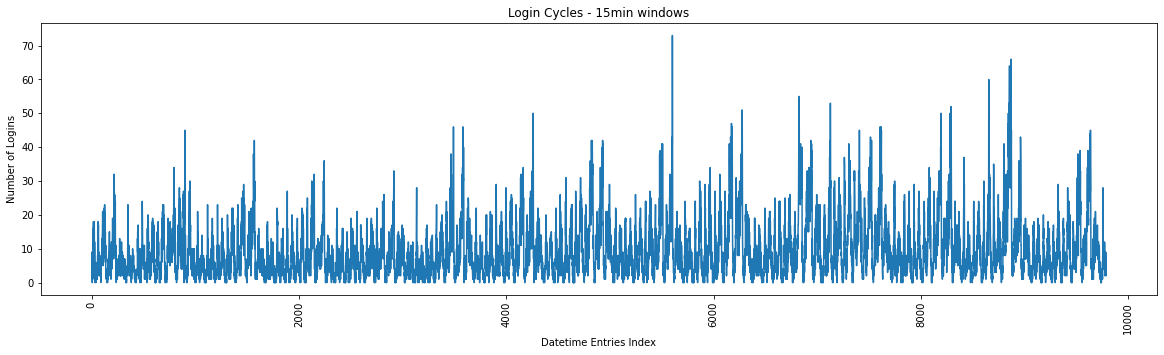

In [172]:
plt.figure(figsize=(20,5))
plt.plot(logins_df.login_activity_15min)
plt.title("Login Cycles - 15min windows")
plt.xlabel("Datetime Entries Index")
plt.ylabel("Number of Logins")
plt.xticks(rotation=90)

We definitely see cycles in the above dataset. We will zoom on data for further analysis

(0.0, 35.0)

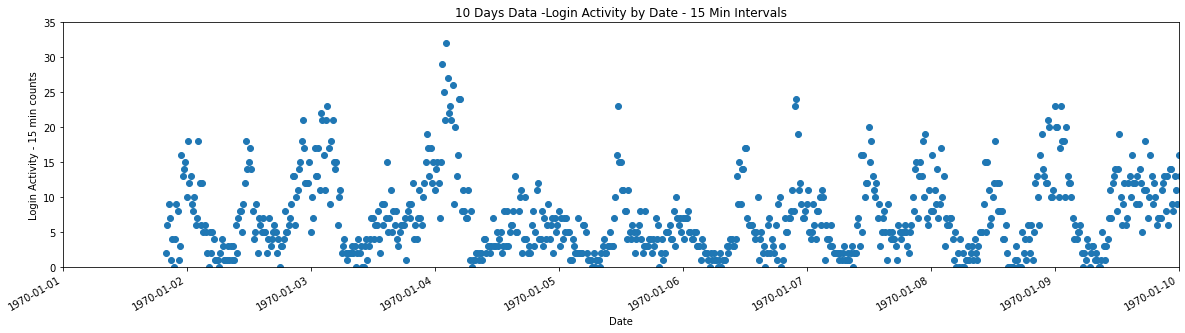

In [173]:
# Zomming in only 10 days to look at trends
fig, ax = plt.subplots(figsize=(20,5))
ax.plot_date(logins_df.login_time, logins_df.login_activity_15min)
fig.autofmt_xdate()
ax.set_xlabel('Date')
ax.set_ylabel('Login Activity - 15 min counts')
ax.set_title('10 Days Data -Login Activity by Date - 15 Min Intervals')
ax.set_xlim([datetime.date(1970, 1, 1), datetime.date(1970, 1, 10)])
ax.set_ylim([0, 35])

(0.0, 70.0)

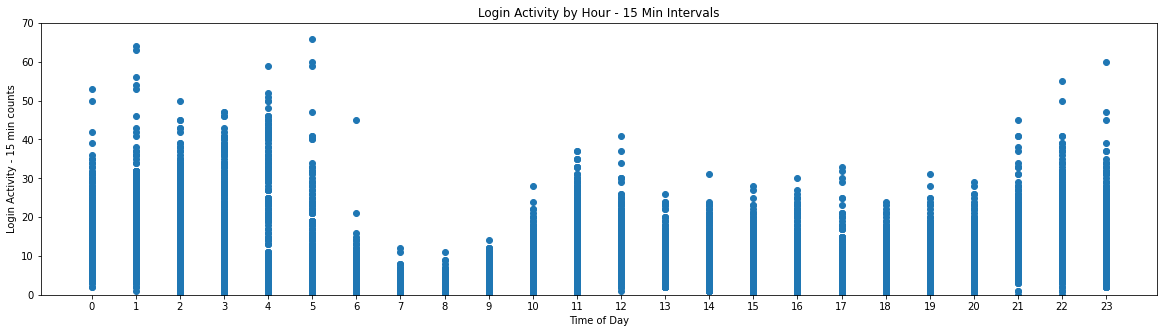

In [176]:
fig, ax = plt.subplots(figsize=(20,5))
x = logins_df['hour_of_day']
y = logins_df['login_activity_15min']
ax.scatter(x, y)
plt.xticks(range(max(logins_df.hour_of_day)+1))
ax.set_xlabel('Time of Day')
ax.set_ylabel('Login Activity - 15 min counts')
ax.set_title('Login Activity by Hour - 15 Min Intervals')
ax.set_ylim([0, 70])

#### We can see that login activity is high at midnight and low during early hours of the morning. It slightly picks up in the afternoon but definitely higher in teh evening

(0.0, 70.0)

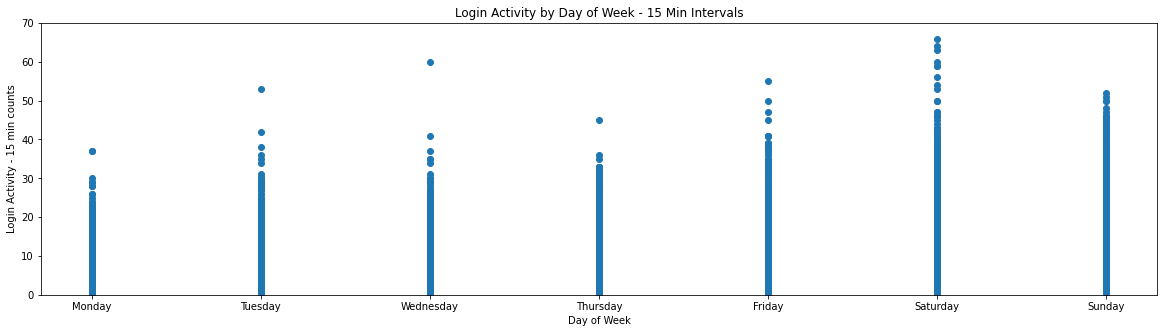

In [179]:
fig, ax = plt.subplots(figsize=(20,5))
x = logins_df['day_of_week']
y = logins_df['login_activity_15min']
ax.scatter(x, y)
x_ticks = [0,1,2,3,4,5,6]
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.xticks(x_ticks,days_of_week)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Login Activity - 15 min counts')
ax.set_title('Login Activity by Day of Week - 15 Min Intervals')
ax.set_ylim([0, 70])

#### We can observe that login activity is lowest on Monday and highest on the weekend especially Saturday

(0.0, 70.0)

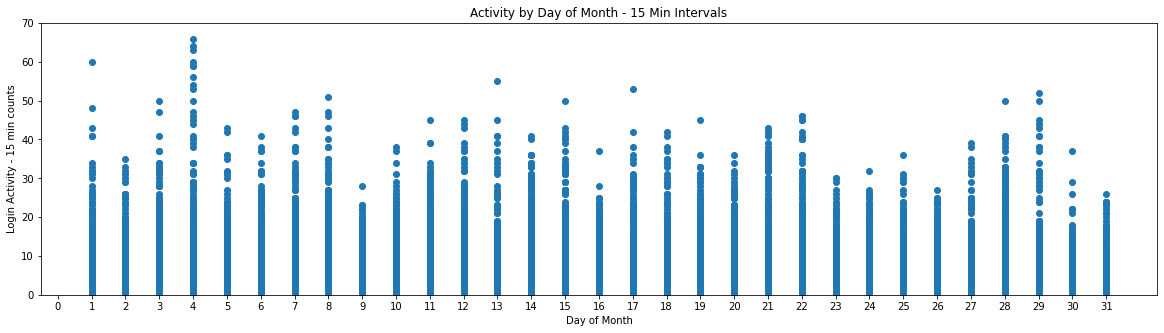

In [181]:
fig, ax = plt.subplots(figsize=(20,5))
x = logins_df['day_of_month']
y = logins_df['login_activity_15min']
ax.scatter(x, y)
plt.xticks(range(max(logins_df.day_of_month)+1))
ax.set_xlabel('Day of Month')
ax.set_ylabel('Login Activity - 15 min counts')
ax.set_title('Activity by Day of Month - 15 Min Intervals')
ax.set_ylim([0, 70])

#### Again in this monthly data, we again see cycle of lower activity during weekdays and higher on weekends

(0.0, 70.0)

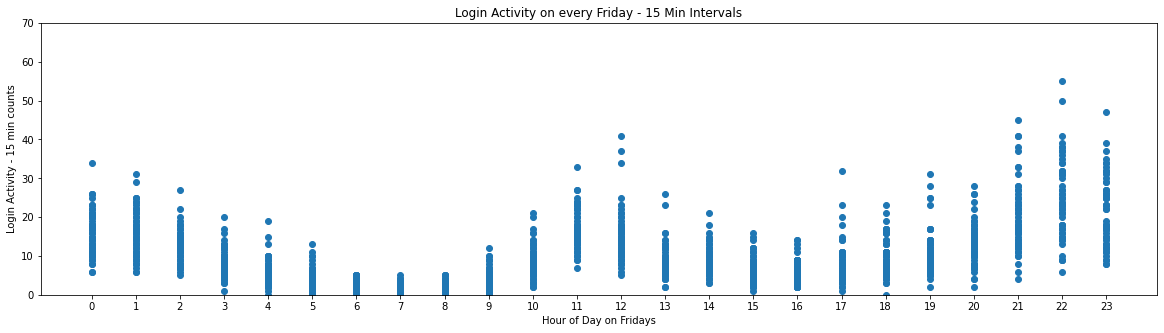

In [182]:
# Login activity during the long weekends
fig, ax = plt.subplots(figsize=(20,5))
x = logins_df.loc[logins_df['day_of_week_name']=="Friday", ['hour_of_day']]
y = logins_df.loc[logins_df['day_of_week_name']=="Friday", ['login_activity_15min']]
ax.scatter(x, y)
plt.xticks(range(max(logins_df.hour_of_day)+1))
ax.set_xlabel('Hour of Day on Fridays')
ax.set_ylabel('Login Activity - 15 min counts')
ax.set_title('Login Activity on every Friday - 15 Min Intervals')
ax.set_ylim([0, 70])

In [183]:
# Calculating the mean by hour of login_activity each day of the week
y = []
for day in days_of_week:
    mean_login_activity_hour_for_day = logins_df.loc[logins_df['day_of_week_name']==day, ['hour_of_day','login_activity_hour']].groupby(by='hour_of_day').agg(np.mean).login_activity_hour.to_list()
    y.append(mean_login_activity_hour_for_day)

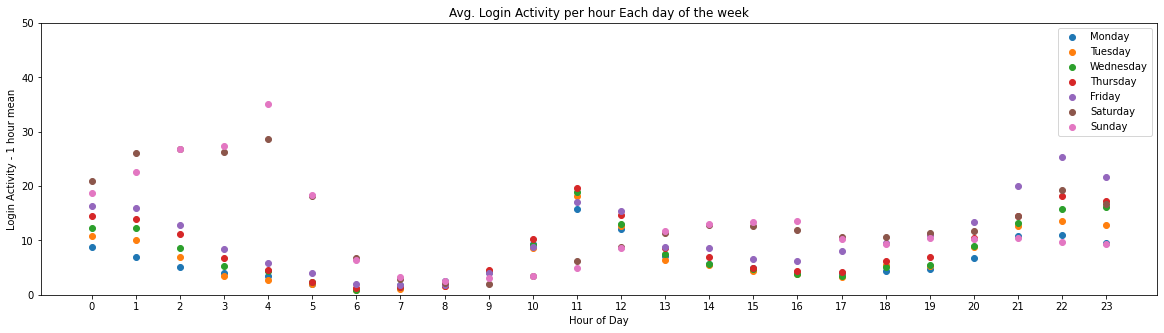

In [184]:
fig, ax = plt.subplots(figsize=(20,5))
plt.xticks(range(max(logins_df.hour_of_day)+1))
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Login Activity - 1 hour mean')
ax.set_title('Avg. Login Activity per hour Each day of the week')
ax.set_ylim([0, 50])
for i in range(len(y)):
    ax.scatter(range(max(logins_df.hour_of_day)+1), y[i], label = days_of_week[i])
ax.legend()    

#### We can see that login activity is flipped on the weekends compared to weekdays during certain time periods. For example, login activity at 4am is much higher on Saturday and Sunday compared to other days. 

### Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    a. How you will implement the experiment?
    
    b. What statistical test(s) you will conduct to verify the significance of the observation
    
    c. How you would interpret the results and provide recommendations to the city operations team along with any caveats.


##### Answer 1:

- They key measure of success would be increased number of drivers during appropriate time windows in both cities measured by driver logins every 15-30 minute window.
- Also, need a way to measure the loss in revenue because of the toll reimbursements.

##### Answer 2:

Experiment - The Ultimate manager of city operations should partner with two top (highest number of drivers) driver partners in both cities for one month with toll reimbursements during different time periods for both cities during weekdays.

(a):
i. The drivers will be reimbursed for tolls going out from Metropolis city during the day time.
ii. The drivers will be reimbursed for tolls going out from Gotham city during the night time.

(b):
We need to measure a few variables:
1. Measure the number of available drivers in each city by each hour of each day of the weekdays.
2. Measure the total revenue for driver partners in each city
3. Measure the revenue for drivers in each city by each hour of each day of the weekdays
4. Measure the total toll bridge costs for drivers
5. Measure the toll bridge costs for drivers by each hour of each day of the weekdays
6. Measure the total toll bridge reimbursements by ultimate managers of city operations
7. Measure the toll bridge reimbursements by ultimate managers of city operations by each hour of each day of the week

The normal distribution of above measured variables will shift depending on the time of day

(c):
- The normal distribution of available drivers in each city during the less activity times should shift to the right. It means the mean should increase. 
- The revenue for drivers should also increase partly because of toll reimbursements.
- The loss of revenue for City Managers becasue of toll reimbursements should not be higher than generated revenue from increase in productivity from meeting the shortage of drivers.


### Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


#### Data description
● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

##### Answer - 1
Only 37.61% of the observed users were retained as per the given dataset

Please see the data cleaning section for more details of EDA

##### Answer - 2

We needed to predict the active status of the users in the 6th month. (Active = True = 1, Inactive = False = 0).

This is a binary classification problem. Given the features, we predict if the user is Active or Inactive.
Given a good set of parameters, binary classification problems can be effciently solved with XGBoost models which is a Graditent boosting ensable method which is what I used here.

The dataset was quite imbalanced. The y_target column (active_status calculated from last_active_date), was balanced by removing the excess number of records of one type, in this case inactive users.

The performance was measured using accuracy_score=0.77, precision=0.77, and recall=0.77 measurements. Given the results, the model performance can be improved with more data. There was not much variance in the results.

##### Answer - 3

Insightes from each feature

● city: Users from Winterfell and King's landing seems to be more active compared from Astapor.

● phone: Phone type seems to have a high impact on User retention as per the charts and feature importances. Maybe iphone user's had a better User Interface.

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: There seems to be small variance in the ratings by drivers for Active users compared to Inactive users

● avg_rating_of_driver: Average of driver seems to be very close for both Active and Inactive Users

● surge_pct: Active Users took slightly more trips with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips user distribution looks very similar for both Active and Inactive users. So not much impact here on Active Status. 

● trips_in_first_30_days: Active users have slightly more trips in first 30days after signup. Therefore, company should encourage users to engage more for retention. Probably provide some insentives in first month. 

● ultimate_black_user: There is definitely high impact on user retention with the users who took an Ultimate Black in their first 30 days

● weekday_pct: Relatively less users had the percent of the user’s trips occurring during a weekday for Active Users compared to Inactive users who mostly had trips occurring guring weekdays. User's probably had more revenue on the weekends during certain time periods of the day.

In [1]:
!ls

logins.json
ultimate_data_challenge.json
ultimate_data_science_challenge.pdf
ultimate-data.ipynb


### Loading the data into pandas dataframe

In [57]:
ultimate_data_df = pd.read_json("ultimate_data_challenge.json")
ultimate_data_df[:10]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0
9,Winterfell,1,2014-01-03,NaN,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0


### Exploritory Data Analysis

In [58]:
ultimate_data_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [59]:
ultimate_data_df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

### Checking the range of signup dates

In [60]:
print(min(ultimate_data_df.signup_date))
print(max(ultimate_data_df.signup_date))

2014-01-01
2014-01-31


### Checking the date range of activity of drivers

In [61]:
print(min(ultimate_data_df.last_trip_date))
print(max(ultimate_data_df.last_trip_date))

2014-01-01
2014-07-01


### Checking for null values in all columns for cleanup purposes

In [62]:
ultimate_data_df.isnull().any()

city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver       True
avg_surge                 False
last_trip_date            False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver       True
dtype: bool

In [63]:
ultimate_data_df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

## Data Cleaning

#### Creating active_status columns with boolean values True = 1, False = 0
- Since we need to predict for the 6th month, we will set all records with last_trip_date>=2014-06-01 = True else False

In [86]:
ultimate_data_df["active_status"] = np.where(ultimate_data_df.last_trip_date>='2014-06-01', 1, 0)

In [87]:
ultimate_data_df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_status
0,King's Landing,4,2014-01-25,4.700000,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.000000,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.300000,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.600000,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.400000,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.000000,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,1
49996,Astapor,1,2014-01-24,4.000000,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,0
49997,Winterfell,0,2014-01-31,5.000000,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,0
49998,Astapor,2,2014-01-14,3.000000,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,0


Text(0, 0.5, 'Counts')

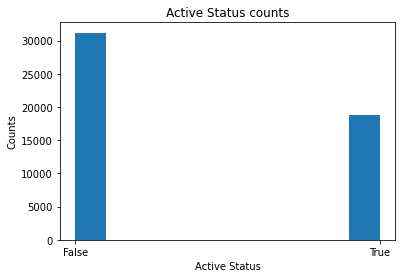

In [88]:
plt.hist(ultimate_data_df.active_status)
plt.title("Active Status counts")
plt.xticks([0,1],["False","True"])
plt.xlabel("Active Status")
plt.ylabel("Counts")

- active_status column looks a little imbalanced. We need to fix it since this is the y_target that we need to predict. 

In [156]:
print("Percent of retained users : ", ultimate_data_df.active_status.value_counts().get(1)/len(ultimate_data_df)*100)

Percent of retained users :  37.608000000000004


#### Storing and converting the active_status data column to list to use in plots

In [89]:
active_status_data = ultimate_data_df.active_status.to_list()

### Fixing null values

#### column_name : avg_rating_of_driver

In [64]:
# Calculating average ratings of drivers 
average_driver_rating = ultimate_data_df.avg_rating_of_driver.mean()
print("Average driver rating : {}".format(average_driver_rating))

Average driver rating : 4.601559291274655


Text(0.5, 0, 'Ratings')

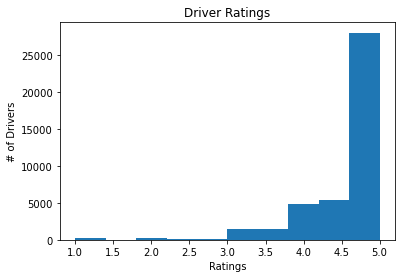

In [65]:
plt.hist(ultimate_data_df.avg_rating_of_driver)
plt.title("Driver Ratings")
plt.ylabel("# of Drivers")
plt.xlabel("Ratings")

In [66]:
print("Total # drivers with missing driver ratings : ",
      ultimate_data_df.avg_rating_of_driver.isnull().sum())

print("Total % of missing driver ratings :", 
      (ultimate_data_df.avg_rating_of_driver.isnull().sum()/ultimate_data_df.trips_in_first_30_days.count())*100)

print("Average # of trips in 1st month with missing driver ratings : ",
      ultimate_data_df.trips_in_first_30_days[ultimate_data_df.avg_rating_of_driver.isnull()].mean())

print("Total drivers with # of trips in 1st month <=1 and missing driver ratings : ",
      ultimate_data_df.trips_in_first_30_days[ultimate_data_df.avg_rating_of_driver.isnull() & (ultimate_data_df.trips_in_first_30_days<=1)].count())

print("Total drivers with # of trips in 1st month =0 and missing driver ratings : ",
      ultimate_data_df.trips_in_first_30_days[ultimate_data_df.avg_rating_of_driver.isnull() & (ultimate_data_df.trips_in_first_30_days==0)].count())

print("# of missing driver ratings with >1 trips in first month: ",
      ultimate_data_df.loc[(ultimate_data_df.avg_rating_of_driver.isnull()) & (ultimate_data_df.trips_in_first_30_days>1), 'trips_in_first_30_days'].count())

print("Max # of trips in 1st month with missing driver ratings : ",
      ultimate_data_df.trips_in_first_30_days[ultimate_data_df.avg_rating_of_driver.isnull()].max())

print("Avg trips in first month of with missing driver ratings with >1 trips in first month: ",
      ultimate_data_df.loc[(ultimate_data_df.avg_rating_of_driver.isnull()) & (ultimate_data_df.trips_in_first_30_days>1), 'trips_in_first_30_days'].mean())

print("# of missing driver ratings with last_trip_date >= 2014-02-01: ",
      ultimate_data_df.last_trip_date[(ultimate_data_df.avg_rating_of_driver.isnull()) & (ultimate_data_df.last_trip_date>='2014-02-01')].count())

print("# of missing driver ratings with last_trip_date >= 2014-02-01 and # of trips in first month >=1: ",
      ultimate_data_df.last_trip_date[(ultimate_data_df.avg_rating_of_driver.isnull()) & (ultimate_data_df.last_trip_date>='2014-02-01') & (ultimate_data_df.trips_in_first_30_days>=1)].count())

Total # drivers with missing driver ratings :  8122
Total % of missing driver ratings : 16.244
Average # of trips in 1st month with missing driver ratings :  0.5933267668062053
Total drivers with # of trips in 1st month <=1 and missing driver ratings :  7736
Total drivers with # of trips in 1st month =0 and missing driver ratings :  3749
# of missing driver ratings with >1 trips in first month:  386
Max # of trips in 1st month with missing driver ratings :  5
Avg trips in first month of with missing driver ratings with >1 trips in first month:  2.155440414507772
# of missing driver ratings with last_trip_date >= 2014-02-01:  5477
# of missing driver ratings with last_trip_date >= 2014-02-01 and # of trips in first month >=1:  1728


- The missing driver ratings account for 16.244% of total data. 
- Based on the above analysis, the ratings for drivers with last_trip_date>=2014-02-01 (5477) will be replaced by average rating.
- Rest (2645) will be replaced with values from the column avg_rating_by_driver since these two columns should have high correlation
- If there are still null values, then they will be replaced with 0.

In [67]:
# the ratings for drivers with last_trip_date>=2014-02-01 (5477) is being replaced by average rating 
ultimate_data_df.loc[(ultimate_data_df.avg_rating_of_driver.isnull()) 
                     & (ultimate_data_df.last_trip_date>='2014-02-01'), "avg_rating_of_driver"] = average_driver_rating 

In [68]:
print("Total # drivers with missing driver ratings : ",
      ultimate_data_df.avg_rating_of_driver.isnull().sum())

Total # drivers with missing driver ratings :  2645


In [69]:
ultimate_data_df.loc[(ultimate_data_df.avg_rating_of_driver.isnull()) 
                     & (ultimate_data_df.last_trip_date<'2014-02-01'), "avg_rating_of_driver"] = ultimate_data_df.loc[(ultimate_data_df.avg_rating_of_driver.isnull()) 
                                                                                                                      & (ultimate_data_df.last_trip_date<'2014-02-01'), "avg_rating_by_driver"]

In [70]:
print("Total # drivers with missing driver ratings : ",
      ultimate_data_df.avg_rating_of_driver.isnull().sum())

Total # drivers with missing driver ratings :  19


In [71]:
ultimate_data_df.loc[(ultimate_data_df.avg_rating_of_driver.isnull()) 
                     & (ultimate_data_df.last_trip_date<'2014-02-01'), "avg_rating_of_driver"] = 0

In [72]:
print("Total # drivers with missing driver ratings : ",
      ultimate_data_df.avg_rating_of_driver.isnull().sum())

Total # drivers with missing driver ratings :  0


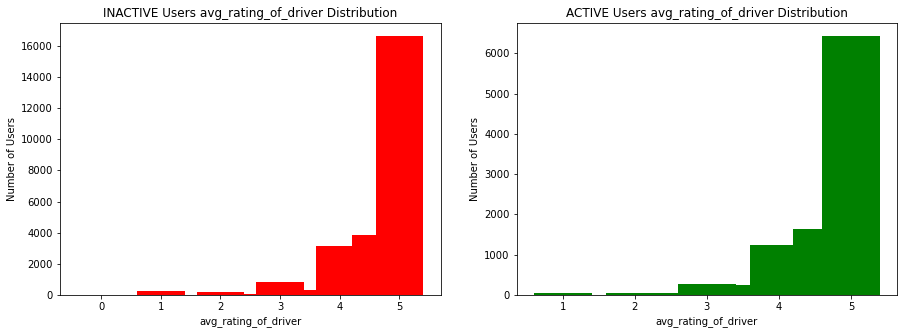

In [127]:
i = 0
titles = ["INACTIVE Users avg_rating_of_driver Distribution", "ACTIVE Users avg_rating_of_driver Distribution"]
colors = ["red", "green"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for active_status_value in [0,1]:
    x = ultimate_data_df.avg_rating_of_driver[ultimate_data_df.active_status==active_status_value].value_counts().keys().to_list()
    y = ultimate_data_df.avg_rating_of_driver[ultimate_data_df.active_status==active_status_value].value_counts().to_list()
    axs[i].bar(x, y, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set(xlabel='avg_rating_of_driver', ylabel='Number of Users')
    i += 1

In [128]:
plt.close()

#### column_name : phone

In [73]:
print("Total number of missing phone column values : {}".format(ultimate_data_df.phone.isnull().sum()))
print("Phone column values : {}".format(
    ultimate_data_df.phone.unique()))

Total number of missing phone column values : 396
Phone column values : ['iPhone' 'Android' None]


In [74]:
print("String counts of each type:\n",ultimate_data_df["phone"].value_counts())
total_string_counts = ultimate_data_df["phone"].value_counts().get('iPhone') + ultimate_data_df["phone"].value_counts().get('Android')
print("\n% of iPhones: {} \n% of Andriods : {}".format(
    ultimate_data_df["phone"].value_counts().get('iPhone')/total_string_counts*100, 
    ultimate_data_df["phone"].value_counts().get('Android')/total_string_counts*100))

String counts of each type:
 iPhone     34582
Android    15022
Name: phone, dtype: int64

% of iPhones: 69.71615192323199 
% of Andriods : 30.283848076768006


Missing values will be proportionally assigned to "iPhone" and "Android" strings

In [75]:
# calculating number of records to assign "iPhone" string value
num_of_iphones_for_missing_values = round(ultimate_data_df.phone.isnull().sum() * 0.70)
num_of_iphones_for_missing_values

277

In [76]:
# creating a temp list of index values where phone=None
index_list_missing_phone_values = ultimate_data_df.index[ultimate_data_df.phone.isnull()].tolist()
# Assigning 70% of records in above list to "iPhone"
ultimate_data_df.loc[ultimate_data_df.index.isin(index_list_missing_phone_values[:num_of_iphones_for_missing_values]), "phone"] = 'iPhone'
# Assigning the rest to "Android"
ultimate_data_df.loc[ultimate_data_df.phone.isnull(), 'phone'] = 'Android'

In [77]:
print("Total number of missing phone column values : {}".format(ultimate_data_df.phone.isnull().sum()))

Total number of missing phone column values : 0


In [78]:
x_phone_data = ultimate_data_df.phone.value_counts().keys().to_list()
y_phone_data = ultimate_data_df.phone.value_counts().to_list()

Text(0, 0.5, 'Number of Users')

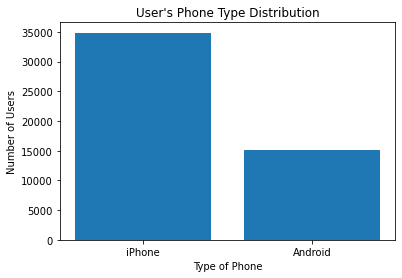

In [80]:
plt.bar(x_phone_data, y_phone_data)
plt.title("All User's Phone Type Distribution")
plt.xlabel("Type of Phone")
plt.ylabel("Number of Users")

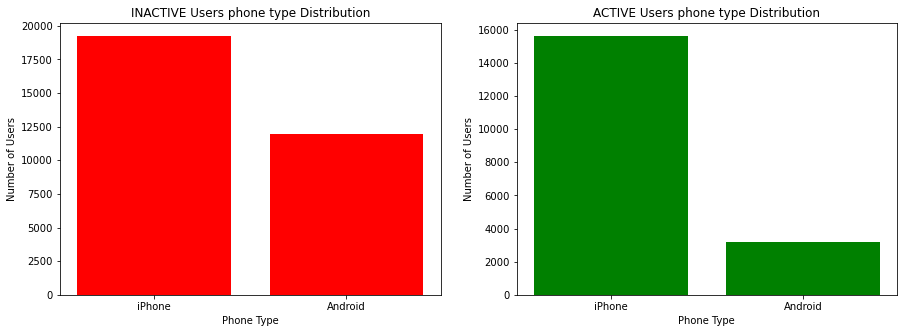

In [126]:
i = 0
titles = ["INACTIVE Users phone type Distribution", "ACTIVE Users phone type Distribution"]
colors = ["red", "green"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for active_status_value in [0,1]:
    x = ultimate_data_df.phone[ultimate_data_df.active_status==active_status_value].value_counts().keys().to_list()
    y = ultimate_data_df.phone[ultimate_data_df.active_status==active_status_value].value_counts().to_list()
    axs[i].bar(x, y, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set(xlabel='Phone Type', ylabel='Number of Users')
    i += 1

In [129]:
plt.close()

#### column=avg_rating_by_driver

In [81]:
print("Total number of missing rating by driver : {}".format(ultimate_data_df.avg_rating_by_driver.isnull().sum()))
print("Mean of avg_rating_by_driver : {}".format(ultimate_data_df.avg_rating_by_driver.mean()))

Total number of missing rating by driver : 201
Mean of avg_rating_by_driver : 4.77815819594771


Text(0, 0.5, ' Number of Ratings')

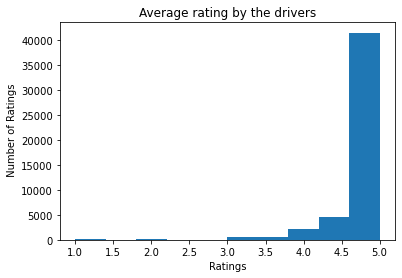

In [82]:
plt.hist(ultimate_data_df.avg_rating_by_driver)
plt.title("Average rating by the drivers")
plt.xlabel("Ratings")
plt.ylabel(" Number of Ratings")

In [83]:
ultimate_data_df[ultimate_data_df.avg_rating_by_driver.isnull()][:30]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
90,Winterfell,1,2014-01-10,5.000000,1.00,2014-02-09,iPhone,0.0,False,0.0,6.28,NaN
274,Astapor,1,2014-01-25,2.000000,4.00,2014-02-09,iPhone,100.0,False,0.0,6.00,NaN
277,Winterfell,1,2014-01-25,0.000000,1.00,2014-01-26,iPhone,0.0,False,0.0,1.82,NaN
536,Winterfell,1,2014-01-18,5.000000,1.00,2014-02-08,Android,0.0,False,100.0,1.41,NaN
857,Winterfell,0,2014-01-11,4.000000,1.00,2014-03-16,iPhone,0.0,False,0.0,0.42,NaN
1021,King's Landing,0,2014-01-23,4.601559,1.75,2014-06-13,iPhone,100.0,True,100.0,2.33,NaN
1073,King's Landing,0,2014-01-19,5.000000,1.00,2014-04-27,Android,0.0,False,0.0,9.21,NaN
1164,Winterfell,1,2014-01-24,2.000000,1.00,2014-01-25,Android,0.0,True,100.0,2.57,NaN
1181,Winterfell,1,2014-01-25,3.000000,1.00,2014-01-25,Android,0.0,False,0.0,24.91,NaN
1205,Winterfell,0,2014-01-18,4.601559,1.00,2014-02-22,Android,0.0,False,100.0,8.94,NaN


- The number of null values of avg_rating_by_driver column is relatively small (201/50000)
- Assigning missing avg_rating_by_driver by values from avg_rating_of_driver since these two columns should have high correlation

In [84]:
ultimate_data_df.loc[ultimate_data_df.avg_rating_by_driver.isnull(), "avg_rating_by_driver"] = ultimate_data_df.loc[ultimate_data_df.avg_rating_by_driver.isnull(), "avg_rating_of_driver"]

In [85]:
print("Total number of missing rating by driver : {}".format(ultimate_data_df.avg_rating_by_driver.isnull().sum()))

Total number of missing rating by driver : 0


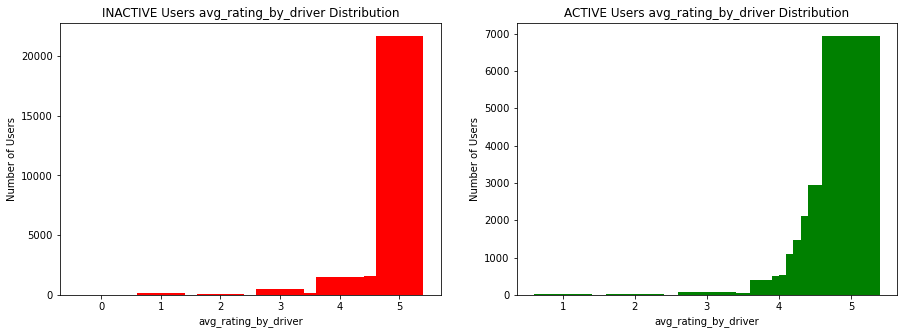

In [133]:
i = 0
titles = ["INACTIVE Users avg_rating_by_driver Distribution", "ACTIVE Users avg_rating_by_driver Distribution"]
colors = ["red", "green"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for active_status_value in [0,1]:
    x = ultimate_data_df.avg_rating_by_driver[ultimate_data_df.active_status==active_status_value].value_counts().keys().to_list()
    y = ultimate_data_df.avg_rating_by_driver[ultimate_data_df.active_status==active_status_value].value_counts().to_list()
    axs[i].bar(x, y, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set(xlabel='avg_rating_by_driver', ylabel='Number of Users')
    i += 1

#### column = trips_in_first_30_days

Text(0, 0.5, 'Number of Users')

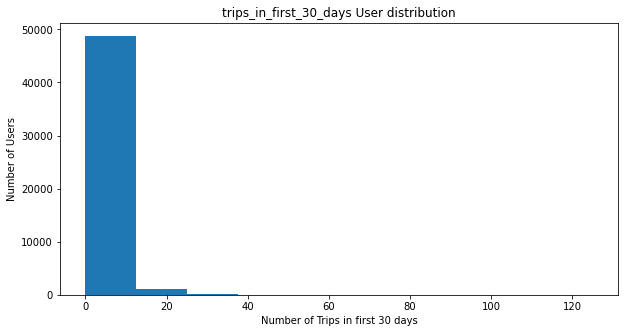

In [75]:
plt.hist(ultimate_data_df.trips_in_first_30_days)
plt.title("trips_in_first_30_days User distribution")
plt.xlabel("Number of Trips in first 30 days")
plt.ylabel("Number of Users")

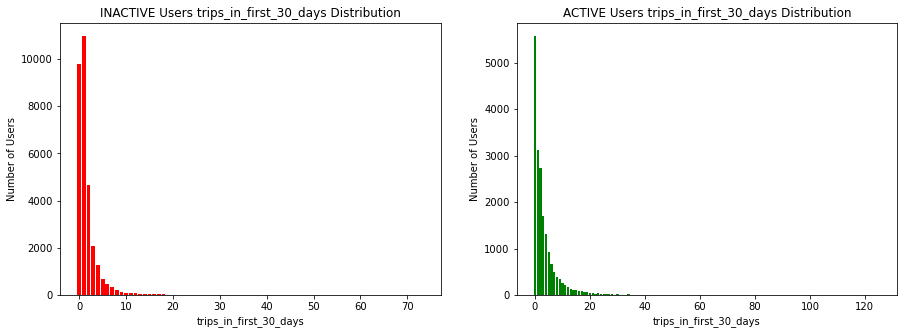

In [134]:
i = 0
titles = ["INACTIVE Users trips_in_first_30_days Distribution", "ACTIVE Users trips_in_first_30_days Distribution"]
colors = ["red", "green"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for active_status_value in [0,1]:
    x = ultimate_data_df.trips_in_first_30_days[ultimate_data_df.active_status==active_status_value].value_counts().keys().to_list()
    y = ultimate_data_df.trips_in_first_30_days[ultimate_data_df.active_status==active_status_value].value_counts().to_list()
    axs[i].bar(x, y, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set(xlabel='trips_in_first_30_days', ylabel='Number of Users')
    i += 1

#### column = city

Text(0, 0.5, 'Number of Users')

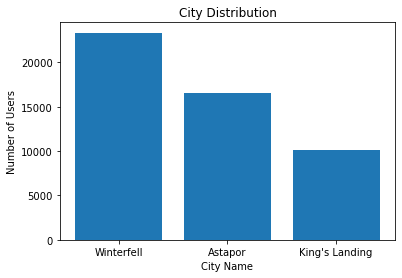

In [51]:
x_city_data = ["Winterfell", "Astapor", "King's Landing"]
y_city_data = ultimate_data_df.city.value_counts().to_list()
plt.bar(x_city_data, y_city_data)
plt.title("City Distribution")
plt.xlabel("City Name")
plt.ylabel("Number of Users")

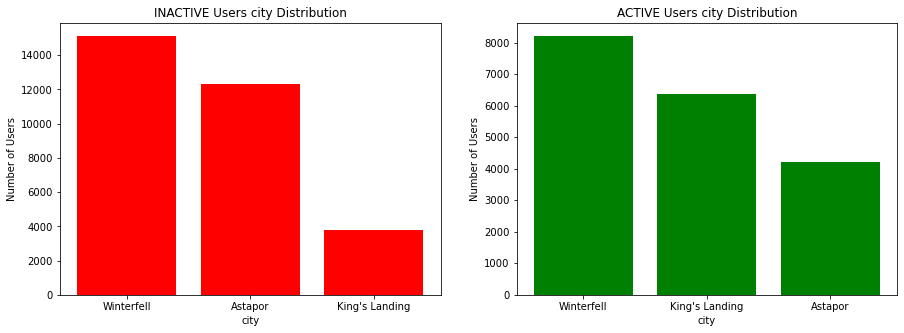

In [135]:
i = 0
titles = ["INACTIVE Users city Distribution", "ACTIVE Users city Distribution"]
colors = ["red", "green"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for active_status_value in [0,1]:
    x = ultimate_data_df.city[ultimate_data_df.active_status==active_status_value].value_counts().keys().to_list()
    y = ultimate_data_df.city[ultimate_data_df.active_status==active_status_value].value_counts().to_list()
    axs[i].bar(x, y, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set(xlabel='city', ylabel='Number of Users')
    i += 1

#### column = avg_surge

Text(0, 0.5, 'Number of Users')

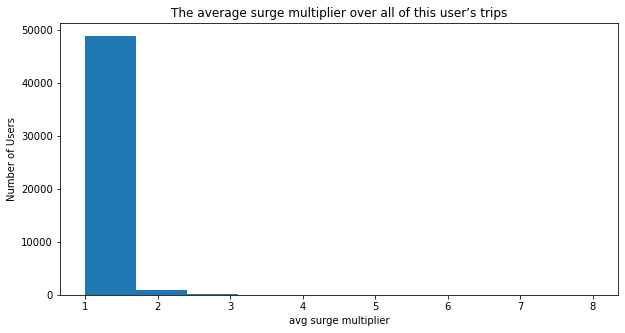

In [92]:
plt.hist(ultimate_data_df.avg_surge)
plt.title("The average surge multiplier over all of this user’s trips")
plt.xlabel("avg surge multiplier")
plt.ylabel("Number of Users")

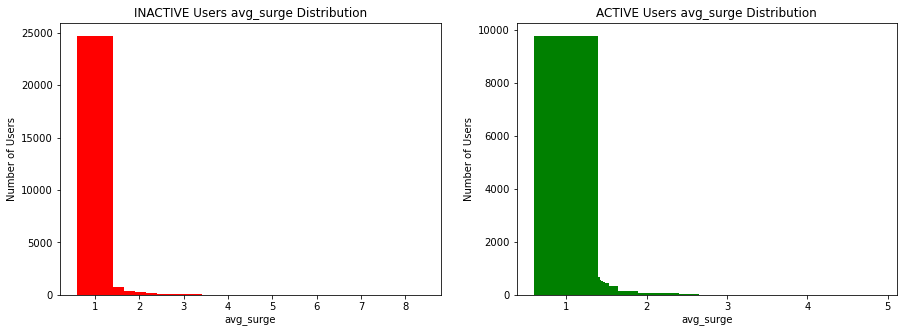

In [136]:
i = 0
titles = ["INACTIVE Users avg_surge Distribution", "ACTIVE Users avg_surge Distribution"]
colors = ["red", "green"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for active_status_value in [0,1]:
    x = ultimate_data_df.avg_surge[ultimate_data_df.active_status==active_status_value].value_counts().keys().to_list()
    y = ultimate_data_df.avg_surge[ultimate_data_df.active_status==active_status_value].value_counts().to_list()
    axs[i].bar(x, y, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set(xlabel='avg_surge', ylabel='Number of Users')
    i += 1

#### column = surge_pct

Text(0, 0.5, 'Number of Users')

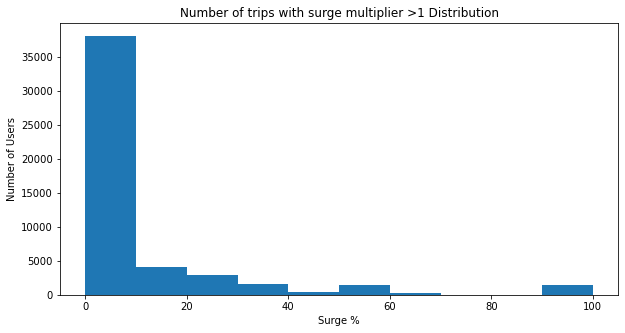

In [79]:
plt.hist(ultimate_data_df.surge_pct)
plt.title("Number of trips with surge multiplier >1 Distribution")
plt.xlabel("Surge %")
plt.ylabel("Number of Users")

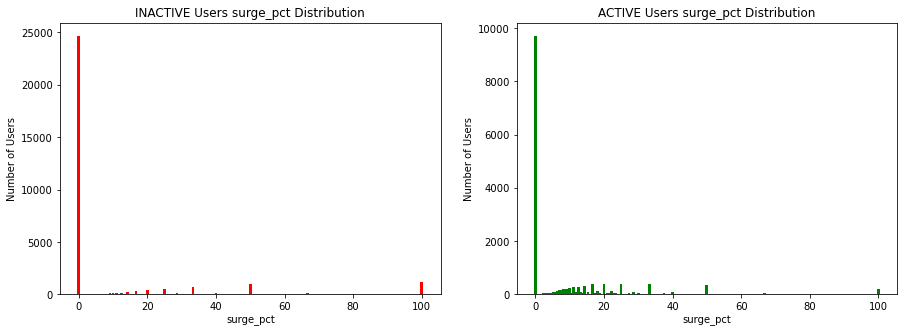

In [137]:
i = 0
titles = ["INACTIVE Users surge_pct Distribution", "ACTIVE Users surge_pct Distribution"]
colors = ["red", "green"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for active_status_value in [0,1]:
    x = ultimate_data_df.surge_pct[ultimate_data_df.active_status==active_status_value].value_counts().keys().to_list()
    y = ultimate_data_df.surge_pct[ultimate_data_df.active_status==active_status_value].value_counts().to_list()
    axs[i].bar(x, y, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set(xlabel='surge_pct', ylabel='Number of Users')
    i += 1

#### column = ultimate_black_user

In [89]:
ultimate_data_df.ultimate_black_user.value_counts()

False    31146
True     18854
Name: ultimate_black_user, dtype: int64

Text(0, 0.5, 'Boolean Ultimate Black User')

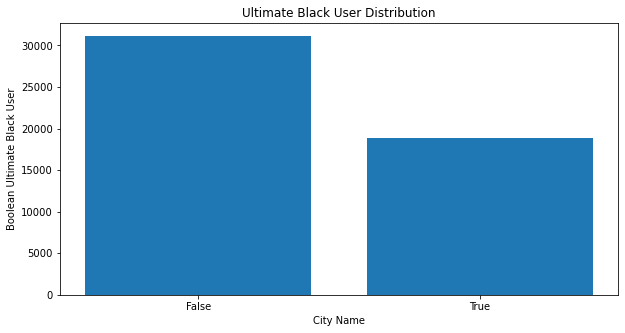

In [90]:
y_ultimate_black_user = ultimate_data_df.ultimate_black_user.value_counts().to_list()
x_ultimate_black_user = ["False", "True"]
plt.bar(x_ultimate_black_user, y_ultimate_black_user)
plt.title("Ultimate Black User Distribution")
plt.xlabel("City Name")
plt.ylabel("Boolean Ultimate Black User")

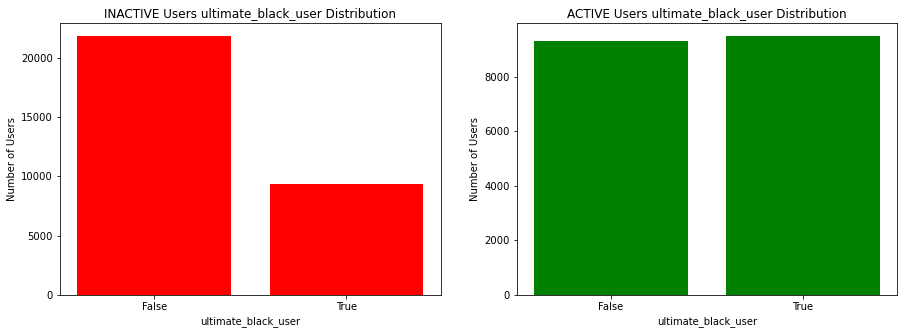

In [148]:
i = 0
titles = ["INACTIVE Users ultimate_black_user Distribution", "ACTIVE Users ultimate_black_user Distribution"]
colors = ["red", "green"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.setp(axs, xticks=[0,1], xticklabels=["False","True"])
for active_status_value in [0,1]:
    x = ultimate_data_df.ultimate_black_user[ultimate_data_df.active_status==active_status_value].value_counts().keys().to_list()
    y = ultimate_data_df.ultimate_black_user[ultimate_data_df.active_status==active_status_value].value_counts().to_list()
    axs[i].bar(x, y, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set(xlabel='ultimate_black_user', ylabel='Number of Users')
    i += 1

#### column = weekday_pct

Text(0, 0.5, 'Number of Users')

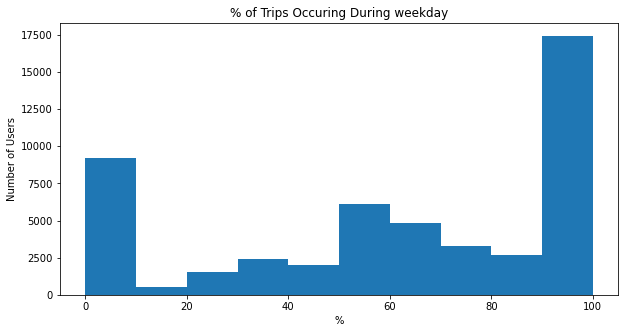

In [82]:
plt.hist(ultimate_data_df.weekday_pct)
plt.title("% of Trips Occuring During weekday")
plt.xlabel("%")
plt.ylabel("Number of Users")

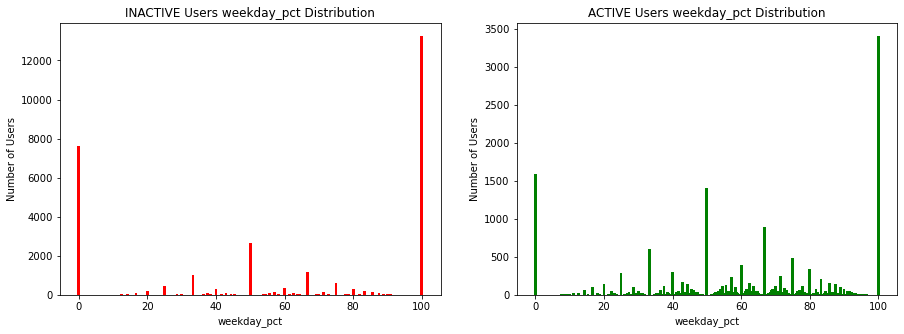

In [153]:
i = 0
titles = ["INACTIVE Users weekday_pct Distribution", "ACTIVE Users weekday_pct Distribution"]
colors = ["red", "green"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for active_status_value in [0,1]:
    x = ultimate_data_df.weekday_pct[ultimate_data_df.active_status==active_status_value].value_counts().keys().to_list()
    y = ultimate_data_df.weekday_pct[ultimate_data_df.active_status==active_status_value].value_counts().to_list()
    axs[i].bar(x, y, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set(xlabel='weekday_pct', ylabel='Number of Users')
    i += 1

#### column = avg_dist

Text(0, 0.5, 'Number of Users')

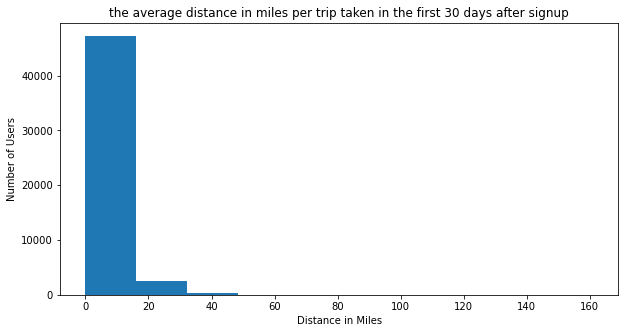

In [83]:
plt.hist(ultimate_data_df.avg_dist)
plt.title("the average distance in miles per trip taken in the first 30 days after signup")
plt.xlabel("Distance in Miles")
plt.ylabel("Number of Users")

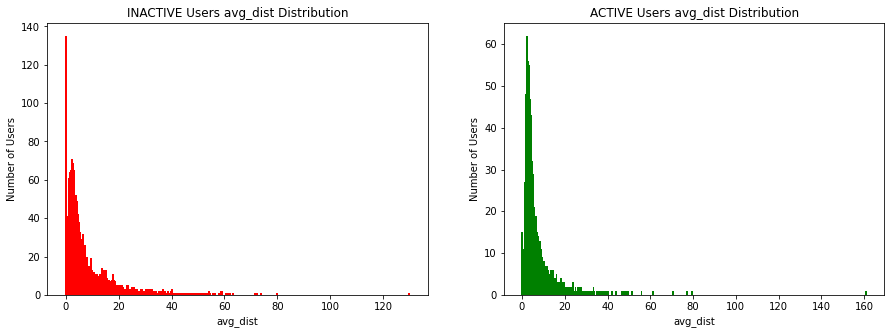

In [154]:
i = 0
titles = ["INACTIVE Users avg_dist Distribution", "ACTIVE Users avg_dist Distribution"]
colors = ["red", "green"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for active_status_value in [0,1]:
    x = ultimate_data_df.avg_dist[ultimate_data_df.active_status==active_status_value].value_counts().keys().to_list()
    y = ultimate_data_df.avg_dist[ultimate_data_df.active_status==active_status_value].value_counts().to_list()
    axs[i].bar(x, y, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set(xlabel='avg_dist', ylabel='Number of Users')
    i += 1

#### Balacing the y_target column "active_status" for modeling

In [36]:
# Get the counts of binary values in the active_status column
ultimate_data_df.active_status.value_counts()

0    31196
1    18804
Name: active_status, dtype: int64

- The number of "False" is significantly higher in the data. This will skew the results towards the "False" status.
- To prevent this, we will match the number of records of both "False" and "True" values.

In [37]:
# Calculating number of records to remove
false_counts_active_status = ultimate_data_df.active_status.value_counts().get(0)
true_counts_active_status = ultimate_data_df.active_status.value_counts().get(1)
remove_n = false_counts_active_status - true_counts_active_status
print("Number of extra false records to remove :",remove_n)

# finding indices of the records we need to remove
indices_false_records = ultimate_data_df.index[ultimate_data_df.active_status==0]
print("Verifying total number of false records in dataframe : ", len(indices_false_records))
print(indices_false_records)

drop_indices = np.random.choice(indices_false_records, remove_n, replace=False)
print("Verifying # of records being removed : ", len(drop_indices))
print(drop_indices)

ultimate_data_df = ultimate_data_df.drop(drop_indices)
print("Number of remaining total records in the dataframe : ", len(ultimate_data_df))
ultimate_data_df[:5]

Number of extra false records to remove : 12392
Verifying total number of false records in dataframe :  31196
Int64Index([    1,     2,     4,     6,     7,     8,     9,    10,    11,
               12,
            ...
            49986, 49987, 49989, 49990, 49992, 49994, 49996, 49997, 49998,
            49999],
           dtype='int64', length=31196)
Verifying # of records being removed :  12392
[10178  8279 21342 ... 42803 32449 43446]
Number of remaining total records in the dataframe :  37608


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_status
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0,1
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0,0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0,0


#### Transforming non-numerical columns to labeled encoders

In [38]:
# Since a lot of data is in the String format which we can not feed to classifier, 
# we will encode the column values to labeled integer values
# We only encode the non-integer type of columns
columns_to_encode = ultimate_data_df.select_dtypes(include=[object]).columns.tolist()
print(columns_to_encode)

#Labeled Encoder
le = preprocessing.LabelEncoder()
le_mapping_last_trip_date = []
for column_name in columns_to_encode:
    ultimate_data_df[column_name] = le.fit_transform(ultimate_data_df[column_name])
#     saving the last_trip_date label enconded classes mapping for later use to divide Train and Test Data
    if column_name == 'last_trip_date':
        le_mapping_last_trip_date = le.classes_

['city', 'signup_date', 'last_trip_date', 'phone']


In [39]:
# Manually encoding boolean column ultimate_black_user
ultimate_data_df["ultimate_black_user"] = np.where(ultimate_data_df.ultimate_black_user, 1, 0)

In [40]:
ultimate_data_df[:5]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_status
0,1,4,24,4.7,1.10,167,1,15.4,1,46.2,3.67,5.0,1
3,1,9,9,4.6,1.14,179,1,20.0,1,80.0,2.36,4.9,1
5,2,2,8,3.5,1.00,156,1,0.0,1,100.0,10.56,5.0,1
7,2,2,27,5.0,1.00,28,1,0.0,0,100.0,2.04,5.0,0
8,2,2,20,4.5,1.00,31,0,0.0,0,100.0,4.36,5.0,0


### Correlation Matrix

In [41]:
params = {'figure.figsize': (10, 5),
         'xtick.labelsize':10,
         'ytick.labelsize':10}
pylab.rcParams.update(params)

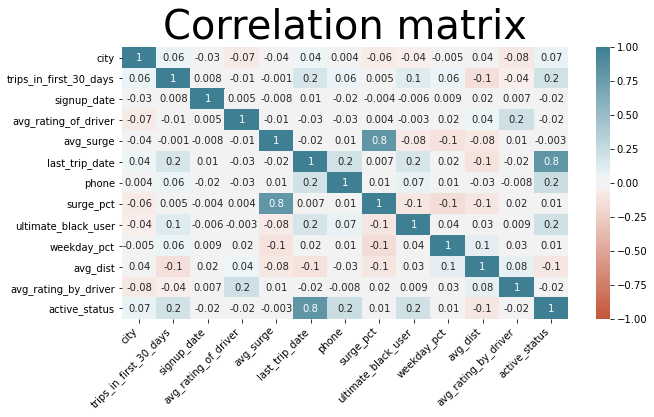

In [42]:
corr_matrix = ultimate_data_df.corr()
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=256),
    fmt='.1g',
    annot=True,
    annot_kws={"size": 10}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title("Correlation matrix", fontsize = 40)
plt.show()

#### Some insights from the coorelation matrix
- "signup_date" and "surge_pct" columns does not seem to have much impact on active_status
- "avg_surge" and "surge_pct" have high correlations, so we may omit "surge_pct" from training if it takes a lot of time
- columns: ["trips_in_first_30_days", "last_trip_date", "phone, "ultimate_black_user" seems to have high impact on "active_status"

### Splitting the datasets into Train, Validation, Test

In [43]:
df_for_modeling = ultimate_data_df

In [44]:
ultimate_data_df_X_columns = ultimate_data_df.columns.to_list()
print(ultimate_data_df_X_columns)
# Excluding last_active_date since it was used to create y_target column (active_status)
ultimate_data_df_X_columns.remove("last_trip_date")
ultimate_data_df_X_columns.remove("active_status")
print(ultimate_data_df_X_columns)

['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver', 'avg_surge', 'last_trip_date', 'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'active_status']
['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver', 'avg_surge', 'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']


In [45]:
X = df_for_modeling[ultimate_data_df_X_columns].to_numpy()
y = df_for_modeling["active_status"].to_numpy()

In [46]:
print("X shape : ",X.shape)
print("y shape : ",y.shape)

X shape :  (37608, 11)
y shape :  (37608,)


In [47]:
# Splitting the dataset for train and test
X, X_test, y, y_test = train_test_split(X, y, test_size=0.05)
print("X shape : ",X.shape)
print("y shape : ",y.shape)
print("X_test shape : ",X_test.shape)
print("y_test shape : ",y_test.shape)

X shape :  (35727, 11)
y shape :  (35727,)
X_test shape :  (1881, 11)
y_test shape :  (1881,)


In [48]:
# Further splitting for train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10)

In [49]:
print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("X_valid shape : ", X_valid.shape)
print("y_valid shape : ", y_valid.shape)

X_train shape :  (32154, 11)
y_train shape :  (32154,)
X_valid shape :  (3573, 11)
y_valid shape :  (3573,)


### Modeling with XGBoost

In [64]:
xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_valid)
print("\nClassification Report \n{}".format(classification_report(y_valid, y_pred, target_names=['Inactive 0', 'Active 1'])))
y_test_pred = xgb_model.predict(X_test)
print("Accuracy score for Test dataset : {}".format(accuracy_score(y_test, y_test_pred)))


Classification Report 
              precision    recall  f1-score   support

  Inactive 0       0.76      0.78      0.77      1770
    Active 1       0.78      0.75      0.77      1803

    accuracy                           0.77      3573
   macro avg       0.77      0.77      0.77      3573
weighted avg       0.77      0.77      0.77      3573

Accuracy score for Test dataset : 0.7799043062200957



Confusion matrix


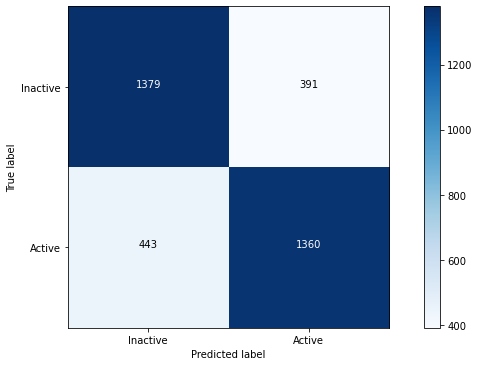

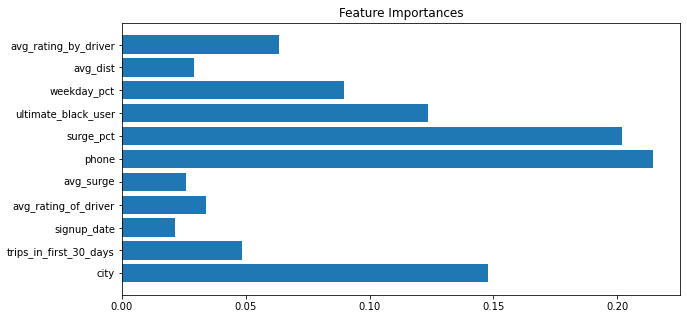

In [65]:
print("\nConfusion matrix")
conf_matrix = confusion_matrix(y_valid, y_pred)
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
tick_marks = np.arange(2)   
classes = ["Inactive","Active"]
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
thresho = conf_matrix.max() / 2.
# The below for loop helps to add numbers in the boxes
for k, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, k, conf_matrix[k, j], horizontalalignment="center", color="white" if conf_matrix[k, j] > thresho else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()
plt.close()

feat_importances = xgb_model.feature_importances_
plt.title("Feature Importances")
plt.barh(range(len(feat_importances)), feat_importances)
plt.yticks(ticks=np.arange(0,len(ultimate_data_df_X_columns)), labels=ultimate_data_df_X_columns)
plt.show()
plt.close()

ROC AUC Score : 0.7666972183836732


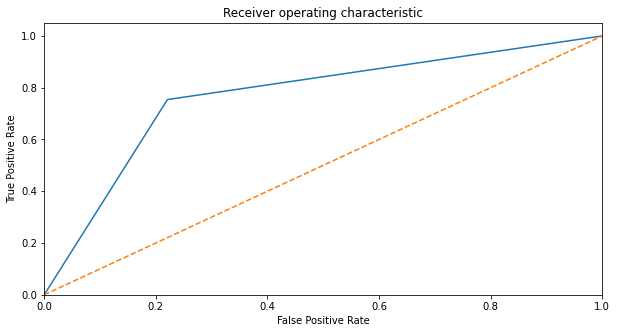

In [66]:
# Below is the ROC curve

print("ROC AUC Score : {}".format(m.roc_auc_score(y_valid, y_pred.round())))

fpr, tpr, threshold = m.roc_curve(y_valid, y_pred.round())
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [67]:
xgb_model.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)>

### Modeling with Grid Search

In [56]:
start_time = time.time()

xgb_param_grid = {'estimator__learning_rate':[0.3, 0.1, 0.2, 0.01, 0.001, 0.4], 
                  'estimator__n_estimators':[400, 300, 200, 500, 100, 10, 50, 30], 
                  'estimator__max_depth':[12, 6, 8, 4, 10, 2, 14]}

xgb_estimator = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)

xgb_grid_search = GridSearchCV(estimator=xgb_estimator, 
                               param_grid=xgb_param_grid, cv=4, n_jobs=7, verbose=10)

xgb_grid_search.fit(X_train, y_train)
print("time : {}".format(time.time()-start_time))

y_valid_pred_gs = xgb_grid_search.predict(X_valid)
print("y validation data accuracy score : ", accuracy_score(y_valid, y_valid_pred_gs))

Fitting 4 folds for each of 336 candidates, totalling 1344 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:   10.5s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:   19.8s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   29.4s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   39.2s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   56.7s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed:  1.7min
[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:  1.9min
[Parallel(n_jobs=7)]: Done  99 tasks      | elapsed:  2.4min
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:  2.7min
[Parallel(n_jobs=7)]: Done 131 tasks      | elapsed:  3.0min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  3.5min
[Parallel(n_jobs=7)]: Done 167 tasks      | elapsed:  3.8min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  4.3min
[Parallel(

time : 1824.2340893745422
y validation data accuracy score :  0.7665827036104114


In [57]:
print(xgb_grid_search.score(X_test, y_test))

0.7799043062200957


In [58]:
print(xgb_grid_search.best_params_)
print(xgb_grid_search.best_score_)
print(xgb_grid_search.best_estimator_)
print(xgb_grid_search.cv_results_)

{'estimator__learning_rate': 0.3, 'estimator__max_depth': 12, 'estimator__n_estimators': 400}
0.7665610174967821
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              estimator__learning_rate=0.3, estimator__max_depth=12,
              estimator__n_estimators=400, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)
{'mean_fit_time': array([9.68079937, 9.90403843, 9.31175524, 9.32528979, 9.5191921 ,
       9.47524905, 9.53143024, 9.51728219, 9.41

Based the CV results above, it seems most parameters had very similar results. 